KELOMPOK SIMULASI DATA MENTENG 22

### EKSTRAK DATA

EKSTRAK FILE SUPAYA DATA TERSTRUKTUR

In [1]:
# Upload file
from google.colab import files
uploaded = files.upload()

Saving Data UAS simdat XML.zip to Data UAS simdat XML.zip


In [2]:
# Library parsing
from bs4 import BeautifulSoup
import zipfile
import os
import re
import glob
import pandas as pd

zip_file = list(uploaded.keys())[0]  # ambil nama file zip
extract_folder = "xml_folder"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [5]:
# FUNGSI EKSTRAKSI
def extract_info_from_xml(filename):
    with open(filename, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file, "xml")

    # JUDUL
    judul = None
    if soup.find("article-title"):
        judul = soup.find("article-title").text.strip()
    elif soup.find("title", {"type": "main"}):
        judul = soup.find("title", {"type": "main"}).text.strip()
    elif soup.find("title"):
        judul = soup.find("title").text.strip()

    # PENULIS
    penulis = []

    # 1. Format NLM/JATS: <contrib contrib-type="author">
    for contrib in soup.find_all("contrib", {"contrib-type": "author"}):
        name_tag = contrib.find("name")
        if name_tag:
            given = name_tag.find("given-names")
            surname = name_tag.find("surname")
            given_text = given.text.strip() if given else ""
            surname_text = surname.text.strip() if surname else ""
            full_name = f"{given_text} {surname_text}".strip()
            if full_name:
                penulis.append(full_name)

    # 2. Format TEI-like: <author><persname><forename>, <surname>
    for author in soup.find_all("author"):
        persname = author.find("persname")
        if persname:
            forename = persname.find("forename")
            surname = persname.find("surname")
            forename_text = forename.text.strip() if forename else ""
            surname_text = surname.text.strip() if surname else ""
            full_name = f"{forename_text} {surname_text}".strip()
            if full_name and full_name not in penulis:
                penulis.append(full_name)

    # Gabungkan
    penulis_str = ", ".join(penulis)

    # TAHUN TERBIT
    tahun_terbit = None

    # 1. Format umum NLM
    pub_date = soup.find("pub-date")
    if pub_date and pub_date.find("year"):
        tahun_terbit = pub_date.find("year").text.strip()

    # 2. Format <date><year>
    elif soup.find("date") and soup.find("date").find("year"):
        tahun_terbit = soup.find("date").find("year").text.strip()

    # 3. Format <date when="YYYY-MM-DD">
    elif soup.find("date", {"when": True}):
        date_when = soup.find("date", {"when": True})["when"]
        tahun_terbit = date_when[:4]  # ambil 4 digit awal

    # 4. Format text string berisi tahun (fallback)
    elif soup.find("date") and soup.find("date").text:
        match = re.search(r"\b(19|20)\d{2}\b", soup.find("date").text)
        if match:
            tahun_terbit = match.group(0)

    # METODOLOGI
    metodologi = None
    method_keywords = [
        "method", "methods", "materials and methods", "data and methods",
        "methodology", "experimental section"
    ]

    # --- 1. Exact match di title/head ---
    for sec in soup.find_all(["sec", "div", "section"]):
        title = sec.find(["title", "head"])
        if title and title.text.strip().lower() in method_keywords:
            paragraf_list = sec.find_all("p")
            metodologi = "\n\n".join(p.text.strip() for p in paragraf_list) if paragraf_list else sec.get_text(separator="\n").strip()
            break

    # --- 2. Partial match (pakai in) ---
    if not metodologi:
        for sec in soup.find_all(["sec", "div", "section"]):
            title = sec.find(["title", "head"])
            if title and any(kw in title.text.strip().lower() for kw in method_keywords):
                paragraf_list = sec.find_all("p")
                metodologi = "\n\n".join(p.text.strip() for p in paragraf_list) if paragraf_list else sec.get_text(separator="\n").strip()
                break

    # --- 3. Full text contains "method" ---
    if not metodologi:
        for sec in soup.find_all(["sec", "div", "section"]):
            full_text = sec.get_text(separator="\n").lower()
            if any(kw in full_text for kw in method_keywords):
                metodologi = sec.get_text(separator="\n").strip()
                break


    # KALIMAT MENGANDUNG "DATA"
    kalimat_berisi_data = []

    # gabungkan semua teks dari abstract sampai body
    teks_kandidat = []
    for tag in soup.find_all(["abstract", "body", "sec", "p"]):
        teks_kandidat.append(tag.get_text(separator=" ").strip())

    full_text = " ".join(teks_kandidat)

    # split per kalimat
    kalimat_list = re.split(r'(?<=[.!?])\s+', full_text)
    kalimat_berisi_data = [kal for kal in kalimat_list if "data" in kal.lower()]

    # Gabungkan kalimat jadi satu string (jika mau versi string)
    kalimat_data_str = " || ".join(kalimat_berisi_data[:10])

    # DATASET ID
    dataset_ids = []

    # 1. Jika ada tag <dataset_id>
    for tag in soup.find_all("dataset_id"):
        if tag.text.strip():
            dataset_ids.append(tag.text.strip())

    # 2. Jika ada tag <id> di dalam <data-set>
    for data_set in soup.find_all("data-set"):
        id_tag = data_set.find("id")
        if id_tag and id_tag.text.strip():
            dataset_ids.append(id_tag.text.strip())

    # 3. Jika ada tag <ext-link> dengan tipe "dataset"
    for ext_link in soup.find_all("ext-link", {"ext-link-type": "dataset"}):
        if ext_link.text.strip():
            dataset_ids.append(ext_link.text.strip())
        elif ext_link.get("xlink:href"):
            dataset_ids.append(ext_link["xlink:href"].strip())

    # 4. Cari semua yang mengandung "https://doi.org/"
    for tag in soup.find_all():
        if tag.string and "https://doi.org/" in tag.string:
            dataset_ids.append(tag.string.strip())
        for attr_value in tag.attrs.values():
            if isinstance(attr_value, str) and "https://doi.org/" in attr_value:
                dataset_ids.append(attr_value.strip())

    # 5. Cari pola khusus seperti CHEMBL, IPR00, GSE, SRP, EMPIAR-, ENSBTAG000, atau IPR
    pattern = r"\b(?:CHEMBL\d+|IPR00\d+|GSE\d+|SRP\d+|EMPIAR-\d+|ENSBTAG000\d+|IPR\d+)\b"

    for tag in soup.find_all():
        # Cek isi teks
        if tag.string:
            matches = re.findall(pattern, tag.string)
            dataset_ids.extend(matches)
        # Cek semua atribut
        for attr_val in tag.attrs.values():
            if isinstance(attr_val, str):
                matches = re.findall(pattern, attr_val)
                dataset_ids.extend(matches)

    # Gabungkan semua dataset_id unik
    dataset_id_str = ", ".join(sorted(set(dataset_ids)))

    return {
        "filename": os.path.basename(filename),
        "judul": judul,
        "penulis": penulis_str,
        "tahun_terbit": tahun_terbit,
        "metodologi": metodologi,
        "kalimat_dengan_data": kalimat_data_str,
        "dataset_id": dataset_id_str
    }

In [6]:
data = []

# Loop semua file XML
for filepath in glob.glob(f"{extract_folder}/**/*.xml", recursive=True):
    try:
        info = extract_info_from_xml(filepath)
        data.append(info)
    except Exception as e:
        print(f"Error di file {filepath}: {e}")

# Buat DataFrame
df = pd.DataFrame(data)

# Simpan ke CSV
df.to_csv("hasil_ekstraksi_data.csv", index=False)

### EXPLORATORY DATA ANALYSIS

In [7]:
from collections import Counter
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
df["tahun_terbit"] = df["tahun_terbit"].astype("Int64")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   filename             400 non-null    object
 1   judul                397 non-null    object
 2   penulis              400 non-null    object
 3   tahun_terbit         381 non-null    Int64 
 4   metodologi           382 non-null    object
 5   kalimat_dengan_data  400 non-null    object
 6   dataset_id           400 non-null    object
dtypes: Int64(1), object(6)
memory usage: 22.4+ KB


In [9]:
import numpy as np

df["judul"] = df["judul"].fillna("judul_tidak_ditemukan")
df["penulis"] = df["penulis"].fillna("penulis_tidak_diketahui")
df["tahun_terbit"] = df["tahun_terbit"].fillna(-1)
df["metodologi"] = df["metodologi"].fillna("")
df["kalimat_dengan_data"] = df["kalimat_dengan_data"].fillna("")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   filename             400 non-null    object
 1   judul                400 non-null    object
 2   penulis              400 non-null    object
 3   tahun_terbit         400 non-null    Int64 
 4   metodologi           400 non-null    object
 5   kalimat_dengan_data  400 non-null    object
 6   dataset_id           400 non-null    object
dtypes: Int64(1), object(6)
memory usage: 22.4+ KB


In [10]:
text_all = (df["metodologi"].fillna("") + " " + df["kalimat_dengan_data"].fillna("")).str.lower().str.cat(sep=' ')

In [11]:
words = re.findall(r'\b\w+\b', text_all)

In [12]:
stop_words = set(stopwords.words("english"))
filtered_words = [word for word in words if word.isalpha() and word not in stop_words]

In [13]:
word_freq = Counter(filtered_words)

In [14]:
print(word_freq.most_common(20))

[('usepackage', 5334), ('data', 5150), ('using', 3446), ('c', 2760), ('used', 2240), ('h', 1895), ('al', 1681), ('et', 1647), ('document', 1527), ('j', 1411), ('n', 1391), ('e', 1262), ('r', 1189), ('analysis', 1180), ('p', 1102), ('two', 1080), ('end', 1063), ('g', 1019), ('gene', 1000), ('based', 979)]


### RULE BASED LOGIC ALGHORITM

In [15]:
df["gabungan_teks"] = df["metodologi"].fillna("") + " " + df["kalimat_dengan_data"].fillna("")

In [16]:
# Keyword list
primer_keywords = [
    "we collected", "interview", "measured", "generated", "field study",
    "questionnaire", "conducted our study", "samples were collected",
    "data was obtained in this study", "experimentally measured",
    "we conducted", "data collected in this study", "our dataset",
    "we gathered", "collected for this research", "enerated during this study", "in-house dataset",
    "experiment produced", "created by authors", "experimentally collected", "primary data", "study participants", "sampled from", "manually collected",
    "we performed an experiment", "collected during our study", "observed during fieldwork",
    "experimental data", "we carried out", "measured in the lab"
    ]

sekunder_keywords = [
    "obtained from", "taken from", "downloaded", "publicly available",
    "secondary data", "retrieved from", "sourced from", "previous study",
    "archival", "published dataset", "borrowed from", "re-used", "reused",
    "existing dataset", "external data", "data were accessed",
    "gathered from", "data from previous studies",
    "from online database", "data reuse", "secondary analysis", "available at", "extracted from", "according to previous data",
    "cited from", "from repository", "already published", "sourced externally", "data citation",
    "we used dataset from", "acquired from repository", "existing public dataset", "open data", "public dataset", "dataset from literature",
    "data collected by others", "used existing data", "external database", "freely available",
    "pre-existing data", "already collected", "downloadable dataset"
]

In [19]:
from rapidfuzz import fuzz

# Fungsi fuzzy matching
def fuzzy_match(text, keyword_list, threshold=85):
    return sum(fuzz.partial_ratio(text, kw) > threshold for kw in keyword_list)

def classify_data_source(text):
    text = text.lower()

    primer_score = sum(bool(re.search(r'\b' + re.escape(kw) + r'\b', text)) for kw in primer_keywords)
    sekunder_score = sum(bool(re.search(r'\b' + re.escape(kw) + r'\b', text)) for kw in sekunder_keywords)

    # Logic klasifikasi
    if primer_score > sekunder_score:
        return "Primary"
    elif sekunder_score > primer_score:
        return "Secondary"
    elif primer_score == sekunder_score and primer_score > 0:
        return "Primary"
    elif "collected" in text and "from previous study" in text:
        return "Secondary"
    elif "collected" in text and "in this study" in text:
        return "Primary"
    else:
        return "Missing"

In [20]:
df["data_source"] = df["gabungan_teks"].apply(classify_data_source)

In [21]:
def extract_data_source_sentence(text):
    source_patterns = [
        "obtained from", "downloaded from", "retrieved from", "sourced from",
        "collected from", "data available at", "taken from", "based on data from",
        "collected via", "data were collected", "data generated", "available at"
    ]

    text = text.lower()
    sentences = re.split(r'(?<=[.!?])\s+', text)

    for kal in sentences:
        if any(kw in kal for kw in source_patterns):
            return kal.strip()

    return "-"

In [22]:
df["sumber_data"] = df["gabungan_teks"].apply(extract_data_source_sentence)

In [23]:
df.to_csv("hasil_ekstraksi_data.csv", index=False)

In [24]:
df.head(10)

,filename,judul,penulis,tahun_terbit,metodologi,kalimat_dengan_data,dataset_id,gabungan_teks,data_source,sumber_data
0,10.1111_2041-210x.13817.xml,Methods in Ecology and Evolution,,-1,We define a wildlife corridor as a ‘band’ of c...,We applied the model to a real dataset for Eld...,"https://doi.org/10.1007/s11590-021-01745-w, ht...",We define a wildlife corridor as a ‘band’ of c...,Primary,-
1,10.1093_nar_gkp1049.xml,GeMMA: functional subfamily classification wit...,"David A. Lee, Robert Rentzsch, Christine Orengo",2010,The GeMMA algorithm is analogous to building a...,The CluSTr database ( 24 ) offers a similarly ...,,The GeMMA algorithm is analogous to building a...,Secondary,ec annotations are taken from the gene3d 7.0 d...
2,10.1002_chem.202001412.xml,Iron(0)‐Mediated Stereoselective (3+2)‐Cycload...,"Philipp Buday, Phillip Seeber, Clara Zens, Has...",2020,,These data suggest that the structure of the o...,,These data suggest that the structure of the ...,Missing,-
3,10.1186_s12868-018-0468-2.xml,PA28αβ overexpression enhances learning and me...,"Julia Adelöf, My Andersson, Michelle Porritt, ...",2018,"C57BL/6N (Charles River, Lyon, France), BALB/c...","Instead, our data suggest that the observed ef...",,"C57BL/6N (Charles River, Lyon, France), BALB/c...",Primary,"blood samples for hematology (in edta tubes, m..."
4,10.21203_rs.3.rs-3338732_v1.xml,Degradation of the 2014-2015 Holuhraun ventpro...,"Sarah Sutton, Jacob Richardson, Patrick Whelle...",2023,Data and Methods\nWe conducted terrestrial las...,"To capture such hazards, our data suggest a ca...","Barlow J, Lim M, Rosser N, et al (2012) Modeli...",Data and Methods\nWe conducted terrestrial las...,Primary,-
5,10.1186_s40168-018-0532-2.xml,A multi-source domain annotation pipeline for ...,"Ari Ugarte, Riccardo Vicedomini, Juliana Berna...",2018,This section explains MetaCLADE’s methodology ...,MetaCLADE is applied to simulated data and to ...,IPR000515,This section explains MetaCLADE’s methodology ...,Secondary,annotations produced by these tools were downl...
6,10.1039_d0sc01197e.xml,Trends in trigonal prismatic Ln-[1]ferrocenoph...,"Trevor P. Latendresse, Veacheslav Vieru, Apoor...",2020,All syntheses and magnetic sample preparation ...,For ESI and crystallographic data in CIF or ot...,,All syntheses and magnetic sample preparation ...,Primary,-
7,10.1111_cas.12935.xml,judul_tidak_ditemukan,,-1,,,,,Missing,-
8,10.1177_0018720820970751.xml,External Human–Machine Interfaces Can Be Misle...,"Anees Ahamed Kaleefathullah, Natasha Merat, Ye...",2020,Sixty participants each experienced 50 crossin...,181) studied an eHMI that showed the status of...,"https://doi.org/10.13039/100010661, https://do...",Sixty participants each experienced 50 crossin...,Missing,-
9,10.3762_bjoc.9.92.xml,Direct alkenylation of indolin-2-ones by 6-ary...,"Sandeep Kumar, Ramendra Pratap, Abhinav Kumar,...",2013,Experimental\nGeneral\nThe reagents and the so...,The crude product was purified by silica gel c...,,Experimental\nGeneral\nThe reagents and the so...,Primary,-


In [25]:
# Tampilkan nilai unik di kolom 'dataset_id'
print(df['dataset_id'].unique())
print(df['dataset_id'].nunique())

['https://doi.org/10.1007/s11590-021-01745-w, https://doi.org/10.1007/s11590‐021‐01745‐w, https://doi.org/10.1111/2041-210X.13817, https://doi.org/10.1111/2041‐210X.13817, https://doi.org/10.5061/dryad.fn2z34tw7'
 ''
 'Barlow J, Lim M, Rosser N, et al (2012) Modeling cliff erosion using negative power law scaling of rockfalls. Geomorphology 139-140:416-424. https://doi.org/10.1016/j.geomorph.2011.11.006, Beakawi Al-Hashemi HM, Baghabra Al-Amoudi OS (2018) A review on the angle of repose of granular materials. Powder Technol 330:397-417. https://doi.org/10.1016/j.powtec.2018.02.003, Bemis K, Walker J, Borgia A, et al (2011) The growth and erosion of cinder cones in Guatemala and El Salvador: Models and statistics. J Volcanol Geotherm Res 201:39-52. https://doi.org/10.1016/j.jvolgeores.2010.11.007, Bonny E, Thordarson T, Wright R, Höskuldsson A, Jónsdóttir I (2018) The Volume of Lava Erupted During the 2014 to 2015 Eruption at Holuhraun, Iceland: A Comparison Between Satellite-and Ground

In [26]:
# Filter hanya baris yang data_source-nya bukan 'missing' atau kosong
df_filtered = df[~df['data_source'].str.lower().isin(['missing', ''])]

# Ambil hanya kolom tertentu
df_selected = df_filtered[['filename', 'dataset_id', 'data_source']]

# Tampilkan (atau simpan)
df_selected.head(20)

,filename,dataset_id,data_source
0,10.1111_2041-210x.13817.xml,"https://doi.org/10.1007/s11590-021-01745-w, ht...",Primary
1,10.1093_nar_gkp1049.xml,,Secondary
3,10.1186_s12868-018-0468-2.xml,,Primary
4,10.21203_rs.3.rs-3338732_v1.xml,"Barlow J, Lim M, Rosser N, et al (2012) Modeli...",Primary
5,10.1186_s40168-018-0532-2.xml,IPR000515,Secondary
6,10.1039_d0sc01197e.xml,,Primary
9,10.3762_bjoc.9.92.xml,,Primary
10,10.1038_sdata.2017.167.xml,,Secondary
11,10.1186_s13071-018-2964-8.xml,SRP093558,Primary
13,10.1039_d1ee03696c.xml,,Secondary


In [27]:
# menghitung nilai null dalam kolom dataset_id
# Hitung baris yang kosong atau NaN
null_count = df['dataset_id'].replace('', np.nan).isna().sum()
print(f"Jumlah nilai null di kolom 'dataset_id': {null_count}")

Jumlah nilai null di kolom 'dataset_id': 253


In [28]:
# Filter hanya baris yang data_source-nya bukan 'missing' atau kosong
df_filtered = df[~df['data_source'].str.lower().isin(['missing', ''])]

# Hanya baris dengan dataset_id yang tidak kosong (baik NaN maupun string kosong)
df_filtered = df[(df['dataset_id'].notna()) & (df['dataset_id'].str.strip() != '')]

# Ambil hanya kolom tertentu
df_selected = df_filtered[['filename', 'dataset_id', 'data_source']]

df_selected.shape[0]

147

In [29]:
# Simpan hasil ke CSV
df_selected.to_csv("filtered_dataset_ids.csv", index=False)


/tmp/ipython-input-30-1539368244.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='tahun_terbit', y='data_source', inner='stick', palette='Dark2')


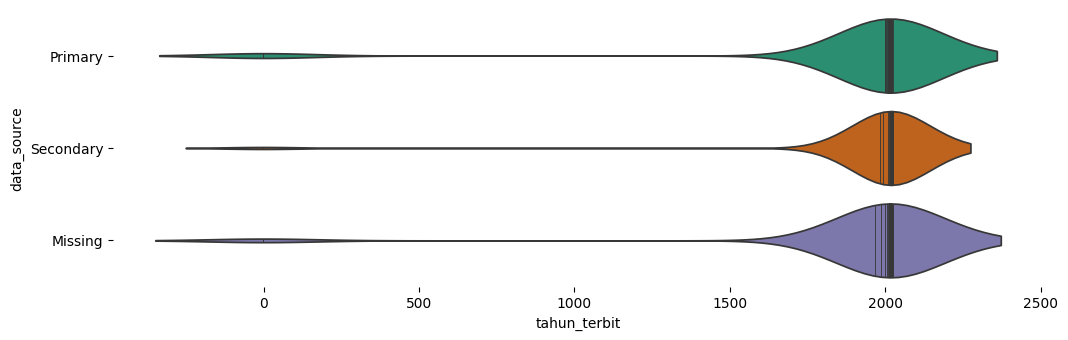

In [30]:
# @title data_source vs tahun_terbit

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['data_source'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='tahun_terbit', y='data_source', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### VISUALISASI

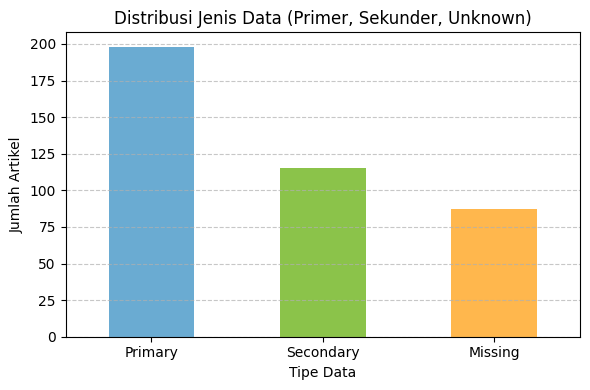

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
df["data_source"].value_counts().plot(kind="bar", color=["#6aabd2", "#8bc34a", "#ffb74d"])
plt.title("Distribusi Jenis Data (Primer, Sekunder, Unknown)")
plt.ylabel("Jumlah Artikel")
plt.xlabel("Tipe Data")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [33]:
import pandas as pd

# 1. Load kedua file CSV
df_pred = pd.read_csv("hasil_ekstraksi_data.csv")
df_label = pd.read_csv("train_labels.csv")

# 2. Bersihkan kolom filename jadi sama seperti article_id
df_pred["article_id"] = df_pred["filename"].str.replace(".xml", "", regex=False)

# 3. Merge berdasarkan article_id
df_merge = pd.merge(df_pred, df_label, on="article_id", how="inner")

# 4. Bandingkan kolom prediksi dan label
df_merge["is_correct"] = df_merge["data_source"] == df_merge["type"]

# 5. Hitung akurasi
accuracy = df_merge["is_correct"].mean() * 100
print(f"Akurasi prediksi: {accuracy:.2f}%")

# (Opsional) Lihat distribusi
print(df_merge["data_source"].value_counts())
print(df_merge["type"].value_counts())

Akurasi prediksi: 45.03%
data_source
Secondary    398
Primary      315
Missing      162
Name: count, dtype: int64
type
Secondary    423
Missing      230
Primary      222
Name: count, dtype: int64


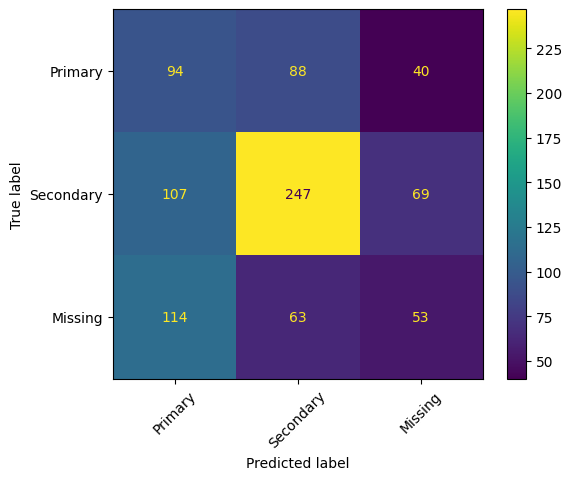

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df_merge["type"], df_merge["data_source"], labels=["Primary", "Secondary", "Missing"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Primary", "Secondary", "Missing"])
disp.plot(xticks_rotation=45)

In [39]:
import pandas as pd

# Membaca file CSV
df = pd.read_csv("hasil_ekstraksi_data.csv")

# Menampilkan informasi dataset
print(df.info())

# Mengisi nilai null di kolom 'dataset_id' dengan 'missing'
df['dataset_id'] = df['dataset_id'].fillna("missing")

# mau apus ".xml" yang ada di kolom filename
df['filename'] = df['filename'].str.replace(".xml", "", regex=False)
# (Opsional) Menampilkan 5 baris pertama untuk memastikan perubahan
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   filename             400 non-null    object
 1   judul                396 non-null    object
 2   penulis              381 non-null    object
 3   tahun_terbit         400 non-null    int64 
 4   metodologi           382 non-null    object
 5   kalimat_dengan_data  395 non-null    object
 6   dataset_id           147 non-null    object
 7   gabungan_teks        400 non-null    object
 8   data_source          400 non-null    object
 9   sumber_data          400 non-null    object
dtypes: int64(1), object(9)
memory usage: 31.4+ KB
None


,filename,judul,penulis,tahun_terbit,metodologi,kalimat_dengan_data,dataset_id,gabungan_teks,data_source,sumber_data
0,10.1111_2041-210x.13817,Methods in Ecology and Evolution,NaN,-1,We define a wildlife corridor as a ‘band’ of c...,We applied the model to a real dataset for Eld...,"https://doi.org/10.1007/s11590-021-01745-w, ht...",We define a wildlife corridor as a ‘band’ of c...,Primary,-
1,10.1093_nar_gkp1049,GeMMA: functional subfamily classification wit...,"David A. Lee, Robert Rentzsch, Christine Orengo",2010,The GeMMA algorithm is analogous to building a...,The CluSTr database ( 24 ) offers a similarly ...,missing,The GeMMA algorithm is analogous to building a...,Secondary,ec annotations are taken from the gene3d 7.0 d...
2,10.1002_chem.202001412,Iron(0)‐Mediated Stereoselective (3+2)‐Cycload...,"Philipp Buday, Phillip Seeber, Clara Zens, Has...",2020,NaN,These data suggest that the structure of the o...,missing,These data suggest that the structure of the ...,Missing,-
3,10.1186_s12868-018-0468-2,PA28αβ overexpression enhances learning and me...,"Julia Adelöf, My Andersson, Michelle Porritt, ...",2018,"C57BL/6N (Charles River, Lyon, France), BALB/c...","Instead, our data suggest that the observed ef...",missing,"C57BL/6N (Charles River, Lyon, France), BALB/c...",Primary,"blood samples for hematology (in edta tubes, m..."
4,10.21203_rs.3.rs-3338732_v1,Degradation of the 2014-2015 Holuhraun ventpro...,"Sarah Sutton, Jacob Richardson, Patrick Whelle...",2023,Data and Methods\nWe conducted terrestrial las...,"To capture such hazards, our data suggest a ca...","Barlow J, Lim M, Rosser N, et al (2012) Modeli...",Data and Methods\nWe conducted terrestrial las...,Primary,-


In [41]:
# mau pilih kolom filename, dataset_id, data_source
df[['filename', 'dataset_id', 'data_source']].to_csv("hasil_final_UAS_SIMDAT.csv", index=False)

files.download("hasil_final_UAS_SIMDAT.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>